In [1]:
# src https://github.com/e-lab/pytorch-linknet/blob/master/models/linknet.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from Oxpet_Dataset import Oxpet_Dataset
from torch.utils.data import DataLoader
import os
import math
import time
import matplotlib.pyplot as plt
from collections import Counter
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [3]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [4]:
class LinkNet(nn.Module):
    """
    Generate Model Architecture
    """

    def __init__(self, n_classes):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNet, self).__init__()

        base = resnet18(pretrained=True)

        self.conv1 = base.conv1
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool

        self.encoder1 = base.layer1
        self.encoder2 = base.layer2
        self.encoder3 = base.layer3
        self.encoder4 = base.layer4

        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)

    def forward(self, x):
        # Initial block
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder blocks
        #d4 = e3 + self.decoder4(e4)
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)

        return y

In [5]:
batch_size = 16
trainset = Oxpet_Dataset(os.path.join("datasets-oxpet", "train","images.h5"),os.path.join("datasets-oxpet", "train","binary.h5"),os.path.join("datasets-oxpet", "train","bboxes.h5"),os.path.join("datasets-oxpet", "train","masks.h5"), require_binary=False, require_bbox=False)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validset = Oxpet_Dataset(os.path.join("datasets-oxpet", "val","images.h5"),os.path.join("datasets-oxpet", "val","binary.h5"),os.path.join("datasets-oxpet", "val","bboxes.h5"),os.path.join("datasets-oxpet", "val","masks.h5"), require_binary=False, require_bbox=False)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=4)
testset = Oxpet_Dataset(os.path.join("datasets-oxpet", "test","images.h5"),os.path.join("datasets-oxpet", "test","binary.h5"),os.path.join("datasets-oxpet", "test","bboxes.h5"),os.path.join("datasets-oxpet", "test","masks.h5"), require_binary=False, require_bbox=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

In [32]:
net = LinkNet(2).to(dev)

# Copy weights of resnet18 into encoder
pretrained_model = resnet18(pretrained=True).to(dev)
for i, j in zip(pretrained_model.modules(), net.modules()):
    if not list(i.children()):
        if i.state_dict() and not isinstance(i, nn.Linear):          
            j.weight.data = i.weight.data

In [33]:
batch_size = batch_size
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
data_size = len(trainloader.dataset)

start = time.time()
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = inputs.to(dev), torch.squeeze(targets.to(dev))  # CrossEntropyLoss requires long type inputs.
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, targets).to(dev)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i == math.ceil(data_size / batch_size) - 1:
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss))
            running_loss = 0.0
            
end = time.time()
print(f'Training done. time: {(end - start) / 60: .2f} mins')

# save trained model
torch.save(net, f'saved_models/linknet_{str(time.time())[-6:]}.pt')
print('Model saved.')

[1,   139] loss: 38.120
Training done. time:  3.66 mins
Model saved.


In [6]:
model = torch.load('saved_models/linknet_140324.pt').to(dev)

In [7]:
# returns class labels given the output of the model
def classify(y, loss):
    if loss == 'BCEWithLogits':
        z = torch.sigmoid(y)
        z[z < 0.5] = 0
        z[z >= 0.5] = 1
    elif loss == 'CrossEntropy':
        z = torch.argmax(y, dim=1, keepdim=True)
    return z

In [8]:
total = len(validset) * 256 * 256
true = 0  # true predictions
p = 0  # true positives + false negatives
tp = 0  # true positives
fp = 0  # false positives

for i, (inputs, targets) in enumerate(validloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, targets = inputs.to(dev), targets.to(dev)
    p += (targets == 1).sum()
    outputs = model(inputs)
    
    # To work with BCEWithLogitsLoss
    # preds = classify(outputs, 'BCEWithLogits')
    
    # To work with CrossEntropyLoss
    preds = classify(outputs, 'CrossEntropy')
    tmp1 = (preds == targets)
    tmp2 = (preds == 1)
    true += tmp1.sum()
    tp += (tmp1 * tmp2).sum()
    fp += (~tmp1 * tmp2).sum()
    
acc = true / total
precision = tp / (tp + fp)
recall = tp / p
f1 = 2 * precision * recall / (precision + recall)
print(f"accuracy: {acc}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1-score: {f1}")

accuracy: 0.9216351509094238
precision: 0.8829044103622437
recall: 0.9113526344299316
f1-score: 0.8969029784202576


In [9]:
testiter = iter(testloader)
inputs, targets = testiter.next()
inputs, targets = inputs.to(dev), targets.to(dev)

In [10]:
outputs = model(inputs)

# To work with BCEWithLogitsLoss
# preds = classify(outputs, 'BCEWithLogits')

# To work with CrossEntropyLoss
preds = classify(outputs, 'CrossEntropy')

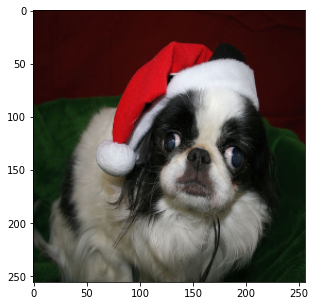

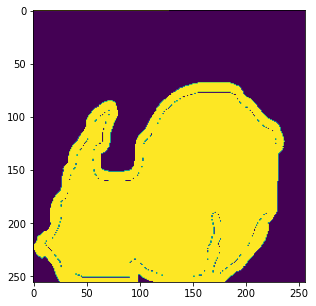

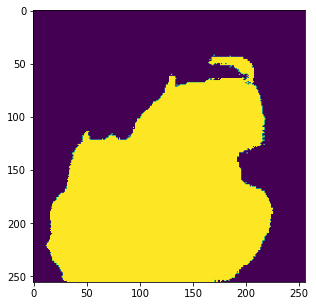

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(inputs[0].cpu().permute(1,2,0).detach().numpy())
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(targets[0].cpu().permute(1,2,0).detach().numpy())
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(preds[0].cpu().permute(1,2,0).detach().numpy())
plt.show()